In [1]:
from src.distance_measures import analyse_video, analyse_image
from src.gaussian_noise import generate_noise
from src.preprocessing import process_image, process_video
import numpy as np
import matplotlib.pyplot as plt
from skimage.color import label2rgb

In [2]:
size = 400
thresh = 0.3
disk = 3.

In [3]:
im = process_video('images/cheese_gel.avi', threshold=thresh, size=size, skip_size=239)[1]
F, G = analyse_image(im, L=50)
y = F/G

In [4]:
def model(thresh, disk):
    noise = generate_noise(size=size, threshold=thresh, disk_size=disk, amount=3)
    F, G = analyse_video(noise, L=50)
    return np.mean(F, axis=0)/np.mean(G, axis=0)

def loss_fn(thresh, disk):
    return np.sum((model(thresh, disk) - y)**2)

In [5]:
max_iter = 1
#loss_list = []
step_thresh, step_disk = (0.01, 0.1)
learning_rate = 0.01

for i in range(max_iter):
    loss = loss_fn(thresh, disk)
    grad1 = (loss_fn(thresh+step_thresh, disk)-loss)/step_thresh
    grad2 = (loss_fn(thresh, disk+step_disk)-loss)/step_disk
    
    thresh -= grad1 * learning_rate
    disk -= grad2 * learning_rate

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

  0%|          | 0/3 [00:00<?, ?it/s]

In [6]:
print(disk)
print(thresh)

3.0005025581152656
0.3279443873978079


  0%|          | 0/3 [00:00<?, ?it/s]

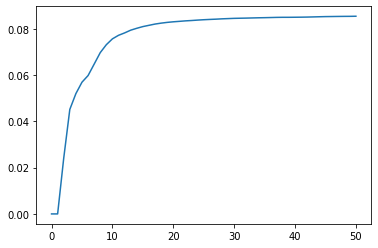

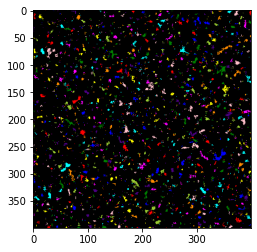

In [7]:
noise = generate_noise(size, threshold=thresh, disk_size=disk, amount=3)
F_noise, G_noise = analyse_video(noise, L=50)
plt.plot(np.mean(F_noise, axis=0)/np.mean(G_noise, axis=0))
plt.show()

plt.imshow(label2rgb(noise[0]))
plt.show()

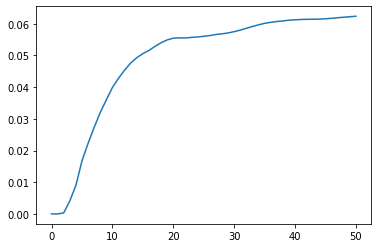

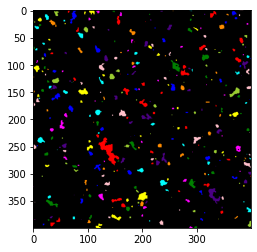

In [8]:
plt.plot(F/G)
plt.show()

plt.imshow(label2rgb(im))
plt.show()